In [2]:
# quick/dirty method to allow importing
import os
os.chdir("../")
os.getcwd()

'/home/eerdem/CELLECT-revised'

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from scripts.circosplot import (Gcircle, plt, mpatches)

In [4]:
# out_dir = 'out/'
# circos_dir = 'out/circos_plots/'
df_all = pd.read_hdf('data/CELLECT_output/data.h5', 'df_all')

(1/1) DTI_mean
Making circos plot...


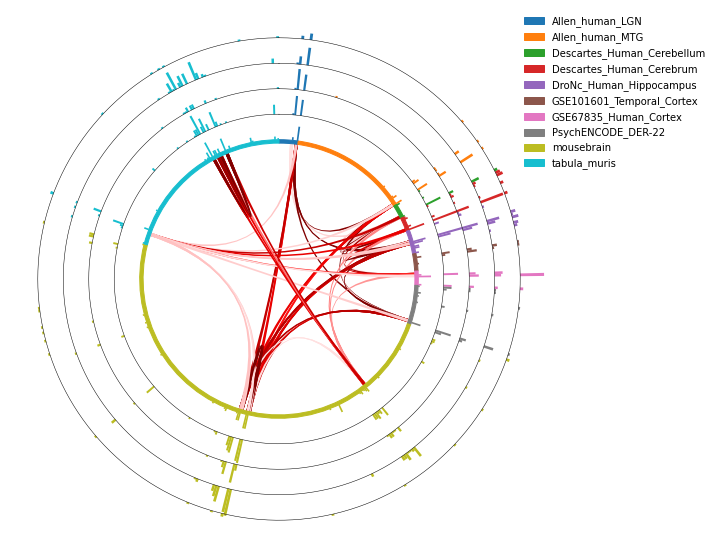

In [3]:
import itertools
from scipy.stats import pearsonr # calculate correlation
from statsmodels.stats.multitest import multipletests 
from matplotlib import cm

# def calculate_pearson(dataframe):
#     corr_list = []
#     pval_list = []
#     gwas_list = dataframe.columns.values
#     for x,y in itertools.combinations(dataframe.columns, 2):
#         corr, pval =  pearsonr(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
#         corr_list.append([x,y,corr])
#         pval_list.append([x,y,pval])
#     corr_list_with_diag = corr_list + [[gwas, gwas, 1] for gwas in gwas_list]
#     pval_list_with_diag = pval_list + [[gwas, gwas, 0] for gwas in gwas_list]
#     corr_df = pd.DataFrame(corr_list_with_diag, columns=['gwasx','gwasy','corr']).pivot(index='gwasx',
#                                                                                         columns='gwasy',
#                                                                                         values='corr')
#     pval_df = pd.DataFrame(pval_list_with_diag, columns=['gwasx','gwasy','pval']).pivot(index='gwasx',
#                                                                                         columns='gwasy',
#                                                                                         values='pval')
#     return corr_df, pval_df

# def correct_pval_correlation(pval_df):
#     '''Uses Bonferroni correction for the input correlation pvalues.'''
#     n = pval_df.shape[0]
#     n_test = (n*(n-1)/2)
#     corrected_pval_df = pval_df * n_test
#     corrected_pval_df[corrected_pval_df > 1] = 1
#     return corrected_pval_df

def calculate_pearson(dataframe, with_diag=False):
    corr_list = []
    gwas_list = dataframe.columns.values
    for x,y in itertools.combinations(dataframe.columns, 2):
        corr, pval =  pearsonr(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
        corr_list.append([x,y,corr, pval])
    if with_diag:
        corr_list = corr_list + [[gwas, gwas, 1, 0] for gwas in gwas_list]
    corr_df = pd.DataFrame(corr_list, columns=['gwasx','gwasy','corr','pval'])
    return corr_df

def get_pthres(corr_df):
    return corr_df[corr_df['corr']<0]['pval'].min()


def chord_plot_pandas(gcircle, row):
        if row['pval_bonferroni']<=0.05:
            dataset_start = []
            for i in [1,2]:
                dataset, celltype = row[f'celltype{i}'].split(', ')
                reset_df = df_circos[(df_circos['specificity_id']==dataset)].reset_index().drop('index', axis=1)
                start = reset_df[(reset_df['annotation']==celltype)].index.values
                dataset_start.append([dataset, start])
            dataset1, start1 = dataset_start[0]
            dataset2, start2 = dataset_start[1]
            gcircle.chord_plot([dataset1,start1-1,start1],[dataset2,start2-1,start2], bottom=bottom,
                               color=cmap(norm(row['corr'])),alpha=1)






param_list_list = [['DTI FA','DTI MD','DTI AD','DTI RD','DTI MO'], 
#                   ['DTI PC1','DTI PC2','DTI PC3','DTI PC4','DTI PC5'],
#                   ['Net100_Node','Net25_Node','Net100_Pair','Net25_Pair','Net_Edge'],
#                   ['Net\d+_Node','Net\d+_Pair', 'Net_Edge'],
#                   ['volume: Cortex','volume: Cingulate','volume: Frontal','volume: Insula',
#                    'volume: Occipital','volume: Parietal','volume: Temporal','volume: Hippocampus'],
#                   ['volume: accumbens','volume: amygdala','volume: caudate','volume: pallidum',
#                    'volume: putamen','volume: thalamus'],
#                   ['area: Cortex','area: Cingulate','area: Frontal','area: Insula',
#                   'area: Occipital','area: Parietal','area: Temporal'],
#                   ['thickness \(adjusted\): Cortex','thickness \(adjusted\): Cingulate',
#                   'thickness \(adjusted\): Frontal','thickness \(adjusted\): Insula',
#                   'thickness \(adjusted\): Occipital','thickness \(adjusted\): Parietal',
#                   'thickness \(adjusted\): Temporal'],
#                   ['[volume|area]: Cortex','[volume|area]: Cingulate','[volume|area]: Frontal','[volume|area]: Insula',
#                   '[volume|area]: Occipital','[volume|area]: Parietal','[volume|area]: Temporal']
                 ]

name_list = ['DTI_mean',
#             'DTI_PC',
#             'Net',
#             'Net_merged',
#             'volume_cortical',
#             'volume_subcortical',
#             'surface_area_cortical',
#             'thickness_cortical',
#             'volume_area_cortical'
           ]

for i, (param_list, name) in enumerate(zip(param_list_list, name_list),1):
    print(f'({i}/{len(name_list)}) {name}')
    circos_dict = {}
    for param in param_list:
        df_circos = pd.concat([df_all[(df_all['gwas'].str.contains(param))][['specificity_id','annotation']],
                           (df_all[(df_all['gwas'].str.contains(param))]['pvalue_bonferroni'] <= 0.05).astype(int)
                           ],
                          axis=1
                         ).groupby(['specificity_id','annotation']).sum().reset_index().rename(columns={'pvalue_bonferroni':'count'})
        N_methods = df_all['n_methods'].unique()
        N_total = df_all[(df_all['gwas'].str.contains(param))]['gwas'].unique().shape[0]*N_methods
        df_circos['freq'] = df_circos['count'] / N_total
        circos_dict[param] = df_circos

    datasets = df_all['specificity_id'].unique()
    
    
    
    
    FREQ_THRES = 0.1

    df_list = [df[df['freq']>=FREQ_THRES] for df in circos_dict.values()]
    annot_list = pd.concat(df_list).sort_values('freq', ascending=False)[['specificity_id','annotation']].drop_duplicates().values.tolist()
#     print(len(annot_list), annot_list)

    ESMU_THRES = 0.5

    celltype_genes_dict = {}
    for dataset, celltype in annot_list:
        cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
        if Path(cellex_file).is_file():
            df_esmu = pd.read_csv(cellex_file, index_col=0)
        elif Path(cellex_file.replace('.mu','.esmu')).is_file():
            df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
        else:
            print('file not found')
        df = df_esmu[celltype]
        df = df[df>ESMU_THRES]
        celltype_genes_dict[f'{dataset}, {celltype}'] = df.index.to_list()


    ESMU_THRES = 0.0

    df_list = []
    for dataset, celltype in annot_list:
        cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
        if Path(cellex_file).is_file():
            df_esmu = pd.read_csv(cellex_file, index_col=0)
        elif Path(cellex_file.replace('.mu','.esmu')).is_file():
            df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
        else:
            print('file not found')
        df = df_esmu[[celltype]]
        df = df[df[celltype]>ESMU_THRES]
    #     display(df)
    #     df.columns = [dataset, celltype]
        df.rename(columns={celltype: f"{dataset}, {celltype}"}, inplace=True)
    #     display(df)
        df_list.append(df)
        
    merged_df = pd.concat(df_list, join='outer', axis=1)
    merged_df.sort_index(axis=1, inplace=True)

    corr_df, pval_df = calculate_pearson(merged_df.fillna(0))

    
    
    
    
    # make circos plots
    print('Making circos plot...')
    gcircle = Gcircle()
    nodes = df_circos[['specificity_id','annotation']].values
    group_color_dict = {name:cm.get_cmap('tab10')(i) for i,name in enumerate(datasets)}

    bottom = 400
    height = 10
    for group in datasets:
    #     print(group, df_circos[df_circos['specificity_id']==group].shape[0])
        gcircle.add_locus(group, df_circos[df_circos['specificity_id']==group].shape[0],
                          bottom=bottom, linewidth=1, interspace=0, height=height,
                          facecolor=group_color_dict[group], edgecolor=group_color_dict[group])


    gcircle.set_locus(figsize=(10, 10)) #Creat figure object   


    cmap = cm.get_cmap('seismic')
    norm = plt.Normalize(-.5, .5)

    corr_df.rename_axis(None)
    corr_df.columns.names = [None]
    links = corr_df.stack().reset_index()
    links.columns = ['celltype1', 'celltype2','corr']
    pval_corrected_df = correct_pval_correlation(pval_df) # Bonferroni
    pval_corrected_df.rename_axis(None)
    pval_corrected_df.columns.names = [None]
    plinks = pval_corrected_df.stack().reset_index()
    plinks.columns = ['celltype1', 'celltype2','pval_bonferroni']
    links = links.merge(plinks, on=['celltype1', 'celltype2'] )
    links = links[links['corr']>0]

    

    links.apply(lambda row: chord_plot_pandas(gcircle, row), axis=1)




    max_val = max([df['freq'].max() for df in circos_dict.values()])
    for i,(param,df) in enumerate(circos_dict.items()):
        for group in datasets:
            try: # catch when there is no data and it returns error
                gcircle.bar_plot(group, df[df['specificity_id']==group]['freq']*((75)/max_val),
                                 bottom=bottom+height+75*i,
                                 facecolor=group_color_dict[group], edgecolor=group_color_dict[group],
                                )
            except ZeroDivisionError:
                continue

        # plot baseline
        if i != 0: # skip first baseline
            x = np.linspace(0,2*np.pi,df['freq'].shape[0])
            y = [bottom+height+75*i]*len(x)
            gcircle.ax.plot(x, y, alpha=1,
                        color='k',
                        lw=.5, zorder=8)

    gcircle.ax.set_ylim(0,bottom+(len(param_list)*80))

    patches = [mpatches.Patch(color=v, label=k) for k,v in group_color_dict.items()]
    gcircle.ax.legend(handles=patches, bbox_to_anchor=(1.3, 1), loc=1, frameon=False)
    # gcircle.ax.text(0,0, param)
    plt.savefig(f"{circos_dir}/circos_chord_plot_positive_{name}.png", dpi=150, bbox_inches='tight')
    # plt.show()

In [4]:
# make .xlsx sheets
with pd.ExcelWriter(f"{circos_dir}circos_sheet_{name}.xlsx") as writer:
    for param,df in circos_dict.items():
        df_sheet = df.copy()
        df_sheet.sort_values('count', ascending=False, inplace=True)
        df_sheet[df_sheet['count']>0].to_excel(writer,sheet_name=param.replace(':','').replace("\\",'').replace(']','').replace('[',''), index=False)
#         display(annot_sign_grouped)
